# CSCI 3202, Spring 2022


# Lecture 16: Games Notebook - Solutions

---

Before we begin, let's load a few packages that we might find useful.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

<br>

<div>
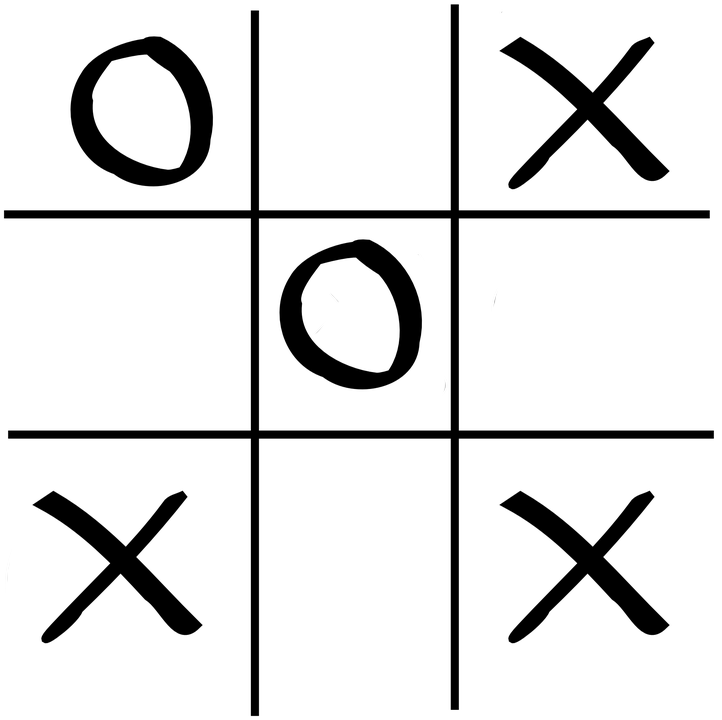
</div>

# Tic-Tac-Toe

Today, the goal is to get an operational `TicTacToe` class, and - aspirationally - play games using `random_player`s.  It turns out that if many, many games are played between two random players, the one who goes first should win about 58% of the time, so that is our benchmark... once we get there.

Let's start by defining a Tic-Tac-Toe board `State` class.  This class includes everything we need to know about the board:
* whose move is it? (`to_move`)
* has anyone won yet? (`utility`)
* what marks are on the board? (`board`, a dictionary that we can modify so the keys are tuples representing a location on the board, and the values are the player, 'X' or 'O', occupying those locations)
* what moves are left to be made? (`moves`, a list of tuples representing vacant board locations)

In [2]:
class State:
    def __init__(self, moves):
        self.to_move = 'X'
        self.utility = 0
        self.board = {}
        self.moves = cp.copy(moves)

Note that we used the `copy` method so that when we modify what moves are left, we do not tamper with the original `moves` object in memory.

Have a look at the image above the "Tic-Tac-Toe" header.  How would we represent that state?

Well, of course we need to construct a `State` first (which we just did).  We'll also need the list of initially available `moves`.  Let's use row/column (matrix-esque) notation.  So (1,1) represents the O in the upper-left, there is another O at (2,2) in the center square, and X's are in (1,3), (3,1) and (3,3).

This means the list of initially available moves is:

In [3]:
moves_initial = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1), (3,2), (3,3)]



### Board and game state

Now we need to modify the board.  Each time a player makes a mark on the board, one of the potential moves has been taken and must be removed from the list, and we need to update whose move it is.  I will add the first move - you do the rest!

In [4]:
state = State(moves_initial)
move = (1,3)
state.board[move] = 'X'
state.moves.remove(move)
state.to_move = 'O' if state.to_move=='X' else 'X'

# make the other moves down here!
move = (1,1)
state.board[move] = 'O'
state.moves.remove(move)

move = (3,1)
state.board[move] = 'X'
state.moves.remove(move)

move = (2,2)
state.board[move] = 'O'
state.moves.remove(move)

move = (3,3)
state.board[move] = 'X'
state.moves.remove(move)

print(state.board)

{(1, 3): 'X', (1, 1): 'O', (3, 1): 'X', (2, 2): 'O', (3, 3): 'X'}


Since it is awfully tedious to keep re-running the same snippet of code, let's define a function to do it for us.

In [5]:
def result(move, state):
    '''
    What is the hypothetical result of move `move` in state `state` ?
    move  = (row, col) tuple where player will put their mark (X or O)
    state = a `State` object, to represent whose turn it is and form
            the basis for generating a **hypothetical** updated state
            that will result from making the given `move`
    '''
    # First, create a copy of the given state. We use `deepcopy` so
    # that we do not prematurely tamper with the actual current 
    # Tic-Tac-Toe state, since we mostly use this method
    # to get hypothetical results as we search our game tree, not
    # for actual moves.
    new_state = cp.deepcopy(state)

    new_state.board[move] = state.to_move
    new_state.moves.remove(move)
    new_state.to_move = 'O' if state.to_move=='X' else 'X'
    new_state.utility = compute_utility(move, state)


    
    return new_state

### Utility

Now a game between two random players can be represented as a loop until either all available moves are taken up (`length(state.moves)==0`) ***or*** one of the players gets 3-in-a-row.  So now we need a function to check whether or not someone has achieved 3-in-a-row by making `move` in `state`.  I've given you some guidelines on how to return the computed `utility`, but there will be some modifications needed depending on how you implement this routine.

<img src="https://imgs.xkcd.com/comics/will_it_work.png" width="230"/>

A couple notes:
* For purposes of getting off the ground during class, there are only 8 possible ways in standard $3 \times 3$ Tic-Tac-Toe in which a player can win.  So it isn't too difficult to hard-code for this situation, if you are stumped. An example portion of this hard-coding solution is given as a comment below.
* You only need to check if the person who is making the `move` has just gotten 3-in-a-row, because the other player can't possibly have changed the utility since they have not moved.
* Remember that `compute_utility` is a **hypothetical** calculation.  We do **not** want to actually modify `state` yet because once we start using alpha-beta pruning, we will need to make judgments on how good numerous possible outcomes are *before* we execute our move and modify the state.
  * To do this, we can use a `deepcopy` of the state board, in which the new board object itself is essentially a new version of the old one and not attached in memory at all.  This line is given for you.

In [6]:
def compute_utility(move, state):
    '''Calculate the utility of making a given move in a given state.
    If X wins, utility is +1; if O wins, utility is -1; if it is a
    draw or nobody has won yet, then utility is 0.'''
    
    
    # create a hypothetical copy of the board, with 'move' executed
    board = cp.deepcopy(state.board)
    board[move] = state.to_move

    # Example hard-coding line:
    # if (state.board.get((1,1))==state.to_move and
    #     state.board.get((1,2))==state.to_move and
    #     state.board.get((1,3))==state.to_move) or
    # ... continue with the other ways in which someone could win...
    
    row, col = move
    player = state.to_move
    ncol=3
    nrow=3
    nwin=3
    
    # what are all the ways 'player' could with with 'move'?

    # check for row-wise win
    in_a_row = 0
    for c in range(1,ncol+1):
        in_a_row += board.get((row,c))==player

    # check for column-wise win
    in_a_col = 0
    for r in range(1,nrow+1):
        in_a_col += board.get((r,col))==player

    # check for NW->SE diagonal win
    in_a_diag1 = 0
    for r in range(row,0,-1):
        in_a_diag1 += board.get((r,col-(row-r)))==player
        
    for r in range(row+1,nrow+1):
        in_a_diag1 += board.get((r,col-(row-r)))==player
        

    # check for SW->NE diagonal win
    in_a_diag2 = 0
    for r in range(row,0,-1):
        in_a_diag2 += board.get((r,col+(row-r)))==player
        
    for r in range(row+1,nrow+1):
        in_a_diag2 += board.get((r,col+(row-r)))==player
        

    if nwin in [in_a_row, in_a_col, in_a_diag1, in_a_diag2]:
        return 1 if player=='X' else -1
    else:
        return 0 
    # your code goes here
    
    
    
    '''
    if # nobody has gotten 3-in-a-row
        return 0
    else:
        return 1 if state.to_move=='X' else -1
        '''   


We can test out our `compute_utility` method by having O make a move in the (1,2) square, and then checking if someone has won yet:

In [7]:
move = (1,2)

# the utility is a *hypothetical* calculation
new_utility = compute_utility(move, state)

# make the actual state update
state = result(move, state)
state.utility = new_utility

# we should stop playing our game once someone has won (i.e., utility != 0)
print('Has someone won yet? {}'.format(state.utility!=0))

Has someone won yet? False


It seems like updating the utility via `compute_utility` really ought to be a part of the `result` function, since the new utility is a direct result of the move.  Go back to add this to your `result` routine.

Now then.  What is the utility if we have X place its next mark at (2,3)?

In [8]:
move = (2,3)
state = result(move, state)

# we should stop playing our game once someone has won (i.e., utility != 0)
print('Has someone won yet? {}'.format(state.utility!=0))

Has someone won yet? True


Let's take our new function for a test drive by re-creating the state in the above picture.  Note that as long as I alternate X and O, the order of the moves is arbitrary (since we don't know in what order that image was created).

In [9]:
state = State(moves_initial)
state = result((1,3), state)
state = result((1,1), state)
state = result((3,1), state)
state = result((2,2), state)
state = result((3,3), state)

Verify that we get the expected results out of the new `state`:
* whose turn should it be?
* what moves are left?
* what does the board look like?

In [10]:
#whose turn should it be?
state.to_move

#what moves are left?
state.moves

[(1, 2), (2, 1), (2, 3), (3, 2)]

It sure would be easier to verify that the proper state had been generated if we had an appropriate helper function to visualize the Tic-Tac-Toe board as it appears in normal life, instead of as a dictionary.  Why, here's one now!  Test it out on the `state` you just generated above.  Note also that this is hard-coded for the $3\times 3$ case currently.

In [11]:
def display(state):
    for row in range(1, 4):
        for col in range(1, 4):
            print(state.board.get((row, col), '.'), end=' ')
        print()

In [12]:
display(state)

O . X 
. O . 
X . X 



### Players

Now let's create a player to play a random legal move in a given Tic-Tac-Toe game state.

In [13]:
def random_player(state):
    '''A player that chooses a legal move at random out of all
    available legal moves in Tic-Tac-Toe state argument'''

    possible_actions = state.moves
    random_move = possible_actions[np.random.randint(low=0, high=len(possible_actions))]

    
    # your code goes here...
    
    return random_move

Now it's time to define a function to play a game between two players. The function should take as arguments the function names for two players (so far, all we have are `random_player`s), and return the final state of the game.
* Start by initializing a new game `State`
* Alternate between players selecting a move and then applying that move to modify the game `state`
* After each player's move, you should have a check to see if the game is over.
* If the game is over, print to the screen the `state.board` and `state.utility`.

In [14]:
def play_game(player1, player2):
    state = State(moves_initial)
    turn = 0
    while turn<=9:
        for player in [player1, player2]:
            turn += 1
            move = player(state)
            state = result(move, state)
            if len(state.moves)==0 or state.utility!=0:
                #print(state.board, state.utility)
                return state


### Let's play a game!

Play a game of Tic-Tac-Toe between two random players. Let's see what happens...

In [15]:
state = play_game(random_player, random_player)
display(state)

O O O 
X X . 
X . . 


### Okay... let's play LOTS OF GAMES!

Now create a loop to play 1000 games of random vs random Tic-Tac-Toe.  Store the resulting utility of each match.  Remember, we are keeping track of the wins/losses of the player who goes first.  Check to making sure that this player's winning percentage is around 58%.

In [16]:
niter = 10000
wins = 0
draws = 0
losses = 0
for k in range(niter):
    out = play_game(random_player, random_player)
    if out.utility==1:
        wins += 1
    elif out.utility==-1:
        losses += 1
    else:
        draws += 1
        
print('First-player winning percentage = {}'.format(wins/niter))

First-player winning percentage = 0.5796


### Now, let's repeat that, with organization!

And below is what we just did in a much more organized manner.

In [17]:
class State:
    def __init__(self, moves):
        self.to_move = 'X'
        self.utility = 0
        self.board = {}
        self.moves = moves

class TicTacToe:
    def __init__(self, nrow=3, ncol=3, nwin=3):
        self.nrow = nrow
        self.ncol = ncol
        self.nwin = nwin
        moves = [(row, col) for row in range(1, nrow + 1) for col in range(1, ncol + 1)]
        self.state = State(moves)

    def result(self, move, state):
        '''
        What is the hypothetical result of move `move` in state `state` ?
        move  = (row, col) tuple where player will put their mark (X or O)
        state = a `State` object, to represent whose turn it is and form
                the basis for generating a **hypothetical** updated state
                that will result from making the given `move`
        '''
        # Don't do anything if the move isn't a legal one
        if move not in state.moves:
            return state
        # Return a copy of the updated state:
        #   compute utility, update the board, remove the move, update whose turn
        new_state = cp.deepcopy(state)
        new_state.utility = self.compute_utility(move, state)
        new_state.board[move] = state.to_move
        new_state.moves.remove(move)
        new_state.to_move = ('O' if state.to_move == 'X' else 'X')
        return new_state

    def compute_utility(self, move, state):
        '''
        What is the utility of making move `move` in state `state`?
        If 'X' wins with this move, return 1;
        if 'O' wins return -1;
        else return 0.
        '''        
        row, col = move
        player = state.to_move
        
        # create a hypothetical copy of the board, with 'move' executed
        board = cp.deepcopy(state.board)
        board[move] = player

        # what are all the ways 'player' could with with 'move'?
        
        # check for row-wise win
        in_a_row = 0
        for c in range(1,self.ncol+1):
            in_a_row += board.get((row,c))==player

        # check for column-wise win
        in_a_col = 0
        for r in range(1,self.nrow+1):
            in_a_col += board.get((r,col))==player

        # check for NW->SE diagonal win
        in_a_diag1 = 0
        for r in range(row,0,-1):
            in_a_diag1 += board.get((r,col-(row-r)))==player
        for r in range(row+1,self.nrow+1):
            in_a_diag1 += board.get((r,col-(row-r)))==player

        # check for SW->NE diagonal win
        in_a_diag2 = 0
        for r in range(row,0,-1):
            in_a_diag2 += board.get((r,col+(row-r)))==player
        for r in range(row+1,self.nrow+1):
            in_a_diag2 += board.get((r,col+(row-r)))==player
        
        if self.nwin in [in_a_row, in_a_col, in_a_diag1, in_a_diag2]:
            return 1 if player=='X' else -1
        else:
            return 0

    def game_over(self, state):
        '''game is over if someone has won (utility!=0) or there
        are no more moves left'''
        return state.utility!=0 or len(state.moves)==0    

    def utility(self, state, player):
        '''Return the value to player; 1 for win, -1 for loss, 0 otherwise.'''
        return state.utility if player=='X' else -state.utility

    def display(self):
        board = self.state.board
        for row in range(1, self.nrow + 1):
            for col in range(1, self.ncol + 1):
                print(board.get((row, col), '.'), end=' ')
            print()

    def play_game(self, player1, player2):
        '''Play a game of tic-tac-toe!'''
        turn_limit = self.nrow*self.ncol  # limit in case of buggy code
        turn = 0
        while turn<=turn_limit:
            for player in [player1, player2]:
                turn += 1
                move = player(self)
                self.state = self.result(move, self.state)
                if self.game_over(self.state):
                    self.display()
                    return self.state.utility                
def random_player(game):
    '''A player that chooses a legal move at random.'''
    possible_actions = game.state.moves
    return possible_actions[np.random.randint(low=0, high=len(possible_actions))]



In [18]:
ttt = TicTacToe(3,3,3)
outcome = ttt.play_game(random_player, random_player)
outcome

X X X 
X O O 
O O X 


1